In [33]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
import IPython
import time
import subprocess
import uuid
import wave, struct, math, random
import scipy.io.wavfile as scipywav
import argparse
import io
from datetime import timedelta as td
from IPython.display import Audio
from scipy.signal import butter, lfilter
from pyAudioAnalysis import audioSegmentation as aS
from operator import itemgetter
from google.cloud import speech
from google.cloud.speech import enums
from google.cloud.speech import types
from google.cloud import storage

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../kota-108-credential.json"

### Convert Audio

In [34]:
def convert_audio(old_audio, new_audio):
    # -hide_banner, -loglevel panic digunakan untuk menghilangkan keluaran ketika process convert
    # -y digunakan untuk auto replace audio ketika convert dengan nama yang sama
    commands = ['ffmpeg', '-hide_banner', '-loglevel', 'panic', '-y', '-i', old_audio, new_audio]
    try:
        subprocess.check_call(commands)
    except subprocess.CalledProcessError as error:
        print(error)
        return False
    
    return True

### Bandpass Filter

In [35]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    
    return y

### Noise Reduction

In [36]:
def _stft(y, n_fft, hop_length, win_length):
    
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

def _istft(y, hop_length, win_length):
    
    return librosa.istft(y, hop_length, win_length)

def _amp_to_db(x):
    
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)

def _db_to_amp(x,):
    
    return librosa.core.db_to_amplitude(x,ref=1.0)

def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20,4))
    cax = ax.matshow(signal, origin = 'lower', aspect='auto', cmap=plt.cm.seismic, vmin=-1*np.max(np.abs(signal)), vmax=np.max(np.abs(signal)))
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
def plot_statistics_and_filter(mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter):
    fig, ax = plt.subplots(ncols=2, figsize=(20,4))
    plt_mean, = ax[0].plot(mean_freq_noise, label='Mean power of noise')
    plt_std, = ax[0].plot(std_freq_noise, label='Std. power of noise')
    plt_std, = ax[0].plot(noise_thresh, label='Noise threshold (by frequency)')
    ax[0].set_title('Threshold for mask')
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin = 'lower')
    fig.colorbar(cax)
    ax[1].set_title('Filter for smoothing Mask')
    plt.show()
    
def removeNoise(audio_clip, noise_clip, n_grad_freq=2, n_grad_time=4, n_fft=4096, win_length=2048, hop_length=512, n_std_thresh=1.5, prop_decrease=1.0, verbose=False, visual=False):
    """
    Menghilangkan noise dari audio berdasarkan clip audio yang memiliki noisi

    Parameter
    ----------
    n_grad_freq : int
        banyaknya channel frekuensi yang akan di lakukan smoothing dengan mask
    n_grad_time :
        banyaknya channel time yang akan dilakukan smoothing dengan mask
    n_fft : int
        nilai frame audio pada kolom STFT
    win_length : int
        masing-masing frame audio windowed dengan 'window()'. Window akan menjadi panjang 'win_length' dan ditambahkan dengan nilai 0 untuk menyamai 'n_fft'
    hop_length : int
        Jumlah frame audio diantara kolom STFT
    n_std_thresh : float
        berapa banyak standar deviasi lebih keras dari nilai rata-rate desibel dari noise (pada setiap level frekuensi) yang dianggap sebagai sinyal
    prop_decrease : float
        sejauh mana noise dikurangi (1 = all. 0 = none)
    visual : bool
        menampilkan plot dari algoritma
    """
    
    if verbose: start = time.time()
        
    # STFT pada noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length) 
    noise_stft_db = _amp_to_db(np.abs(noise_stft))# convert ke dB
    
    # Menghitung statistik pada noise
    mean_freq_noise = np.mean(noise_stft_db, axis =1)
    std_freq_noise = np.std(noise_stft_db, axis =1)
    noise_thresh = mean_freq_noise+std_freq_noise*n_std_thresh
    
    if verbose: print('STFT on noise:', td(seconds=time.time()-start)); start = time.time()
        
    # STFT pada sinyal audio
    if verbose: start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    
    if verbose: print('STFT on signal:',td(seconds=time.time()-start)); start = time.time()
        
    # Menghitung nilai masing pada desibel
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    print(noise_thresh, mask_gain_dB)
    
    # Membuat filter smoothing untuk masking pada waktu dan frekuensi
    smoothing_filter = np.outer(np.concatenate([np.linspace(0,1,n_grad_freq+1,endpoint=False),np.linspace(1,0,n_grad_freq+2)])[1:-1], 
                       np.concatenate([np.linspace(0,1,n_grad_time+1,endpoint=False),np.linspace(1,0,n_grad_time+2)])[1:-1])
    smoothing_filter = smoothing_filter/np.sum(smoothing_filter)
    
    # Menghitung threshold pada setiap frekuensi/time bin
    db_thresh = np.repeat(np.reshape(noise_thresh, [1,len(mean_freq_noise)]), np.shape(sig_stft_db)[1], axis = 0).T
    
    # Mask apabila sinyal diatas nilai threshold
    sig_mask = sig_stft_db<db_thresh
    
    if verbose: print('Masking:', td(seconds=time.time()-start)); start = time.time()
        
    # Convolce mask dengan smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter,  mode='same')
    sig_mask = sig_mask*prop_decrease
    
    if verbose: print('Mask convolution:', td(seconds=time.time()-start)); start = time.time()
        
    # Mask sinyal audio
    sig_stft_db_masked = sig_stft_db *(1-sig_mask) + np.ones(np.shape(mask_gain_dB))*mask_gain_dB*sig_mask # mask real
    sig_imag_masked = np.imag(sig_stft)*(1-sig_mask)
    sig_stft_amp = ((_db_to_amp(sig_stft_db_masked)*np.sign(sig_stft))+(1j * sig_imag_masked))
    
    if verbose: print('Mask application:', td(seconds=time.time()-start)); start = time.time()
        
    # Mengembalikan sinyal audio kedalam bentuk time series
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(np.abs(_stft(recovered_signal, n_fft, hop_length, win_length)))
    
    if verbose: print('Signal recovery:', td(seconds=time.time()-start));
    if visual: plot_spectrogram(noise_stft_db, title='Noise')
    if visual: plot_statistics_and_filter(mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter)
    if visual: plot_spectrogram(sig_stft_db, title='Signal')
    if visual: plot_spectrogram(sig_mask, title='Mask applied')
    if visual: plot_spectrogram(sig_stft_db_masked, title='Masked signal')
    if visual: plot_spectrogram(recovered_spec, title='Recovered spectrogram')
    
    return recovered_signal

### Get Noise

In [37]:
def getNoise(audio, timeStart, timeEnd, sr):
    """
    Deskripsi: 
        Function untuk mengambil noise dari audio.

    Parameter:
        Audio(Array):

        timeStart(Float):

        timeEnd(Float):

        sr(int):

    Return:
        Noise(Array):

    """
    noise = audio[int(sr*timeStart):int(sr*timeEnd)]
    
    return noise

### Speech-to-text

In [38]:
def floatToPcm (audio):
    """
        Deskripsi: Function untuk merubah isi data array audio dari bentuk float kedalam bentuk int16
        
        Parameter: 
            audio: Numpy array
        
        Output:
            audio: Numpy array
    """
    floatLimit = 1.414
    intLimit = 32767
    
    with np.nditer(audio, op_flags=['readwrite']) as x:
        for i in x:
            i /= floatLimit
            i *= intLimit
            
    audio_pcm = audio.astype(np.int16)
    
    return audio_pcm

def writetowav(audio,sr):
    """
        Deskripsi: Function untuk menyimpan data array audio kedalam file wav
        
        Parameter: 
            audio: Numpy array
            sr: integer
            
        Output:
            tempid: String
    """
    tempid = uuid.uuid4().hex[:10].upper()
    
    npaudio = np.array(audio)
    
    audio_pcm = floatToPcm(audio=npaudio)
    scipywav.write("../wavtemp/{}.wav".format(tempid),sr,audio_pcm)
    
    return tempid

def readbinaudio(path):
    """
        Deskripsi: Function untuk membaca file .wav dalam bentuk binary
        
        Parameter: 
            path: String
            
        Output:
            content: String
    """
    with io.open(path, 'rb') as audio_file:
        content = audio_file.read()
    return content

def removebinaudio(path):
    """
        Deskripsi: Function untuk menghapus file
        
        Parameter: 
            path: String
            
        Output:
            
    """
    if os.path.exists(path):
        os.remove(path)

def upload_to_bucket(blob_name, path_to_file, bucket_name):
    """ Upload data to a bucket"""

    # Explicitly use service account credentials by specifying the private key
    # file.
    storage_client = storage.Client()

    #print(buckets = list(storage_client.list_buckets())

    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.upload_from_filename(path_to_file)

    #returns a public url
    return blob.public_url

def transcribeaudio(path):
    """
        Deskripsi: Function untuk melakukan transkripsi audio
        
        Parameter: 
            path: String
            
        Output:
            response: array
    """
    #content = readbinaudio(path)
    client = speech.SpeechClient()
    audio = types.RecognitionAudio(uri=path)

    config = types.RecognitionConfig(
        encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
        language_code='id',
        enable_word_time_offsets=True)

    operation = client.long_running_recognize(config, audio)
    
    response = operation.result(timeout=90)

    for result in response.results:
        print('Transcript: {}'.format(result.alternatives[0].transcript))
    
    return response
        
def processTranscript(response, label_speaker):
    Transcript = []
    for result in response.results:
        alternative = result.alternatives[0]
        for word_info in alternative.words:
            word = word_info.word
            start_time = word_info.start_time
            end_time = word_info.end_time
            
            start_time = start_time.seconds + start_time.nanos * 1e-9
            end_time = end_time.seconds + end_time.nanos * 1e-9
            
            wordDict = {
                "speaker" : label_speaker,
                "word" : word,
                "start_time" : start_time,
                "end_time" : end_time
            }
            
            Transcript.append(wordDict)
    
    return Transcript

def sortTranscript(transcript1, transcript2):
    Transcript = transcript1
    Transcript.extend(transcript2)
    
    sortedTranscript = sorted(Transcript, key=itemgetter('start_time'), reverse = False) 
    
    return sortedTranscript

def generateDialogue(transcript):
    sentence = ''
    dialogue = []
    first = True
    pLabel = 0
    label = transcript[0]['speaker']
    start_time = transcript[0]['start_time']
    
    for i in transcript:
        if i['speaker'] == label:
            sentence += i['word'] + ' '
        else:
            transcript = {
            'timestamp' : str(start_time),
            'label' : label,
            'sentence' : sentence
            }
            sentence = ''

            dialogue.append(transcript)
            
            sentence += i['word'] + ' '
            first = False;
            label = i['speaker']
            start_time = i['start_time']
    
    transcript = {
    'timestamp' : str(start_time),
    'label' : label,
    'sentence' : sentence
    }
    
    dialogue.append(transcript)
            
    return dialogue

Input Audio

In [39]:
audio_path = "../../Resource/Decoded/Sampel2.wav"

Melakukan Convert Audio

In [40]:
# convert_audio(audio_path, audio_path)

# Tahap Pre-Processing

In [41]:
# Input audio, load audio
audio, sr = librosa.load(audio_path, sr=None)

lowcut = 85
highcut = 255

# Melakukan Proses Bandpass Filter
filtered_audio = butter_bandpass_filter(audio, lowcut, highcut, sr)

# Pengambilan clip noise dari audio
noise_audio = getNoise(filtered_audio, 28, 32, sr)

# Proses noise reduction
reduced_audio = removeNoise(filtered_audio, noise_audio)

[-41.216026 -41.375595 -40.381954 ... -78.46254  -78.39949  -78.38049 ] -50.622684


# Speaker Diarization

/Users/nmuntaaza/Desktop/TA/audio_transcribe/venv/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(26, 5 - 1) = 4 components.
  ChangedBehaviorWarning)
/Users/nmuntaaza/Desktop/TA/audio_transcribe/venv/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


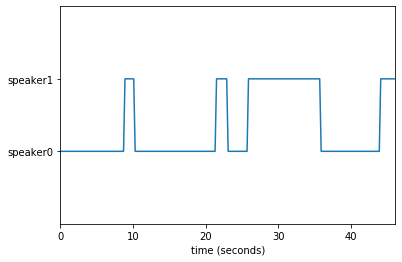

In [42]:
diarization = aS.speakerDiarization(reduced_audio, sr, 2, plot_res=True)

# Pemisahan Suara

In [43]:
"""
Mengambil Label pada 0.2 detik pertama
"""
first = diarization[0]
print("Speaker: {}, len : {}".format(diarization,len(diarization)))
"""
time: Variabel untuk menunjukan panjang/lama satu bagian pembicaraan
first_time: Variabel untuk menunjukan kapan perubahan speaker terjadi
"""
time = 0.0
first_time = 0.0
"""
nol: Variabel untuk menampung audio speaker 1
one: Variabel untuk menampung audio speaker 2
"""
nol = []
one = []

"Melakukan Looping selama ada data label didalam variabel diarization"
for i in diarization:
    "Jika Label pada i belum mengalami perubahan label maka tambahkan panjang pembicaraan label i sepanjang 0.2 detik"
    if i == first:
        time += 0.2
    else:
        "Audio_Clip: Variabel untuk menampung potongan audio dengan start time (first_time) dan end time (time)"
        audio_clip = audio[int(sr*first_time):int(sr*time)]
        
        "Jika Speaker yang berbicara speaker 1 (0)"
        if int(i) < 1:
            #Jika Label Speaker 0
            "Memasukan Potongan Audio kedalam Array Nol dengan waktu yang sama"
            nol[int(sr*first_time):int(sr*time)] = audio_clip
            "Memasukan nilai 0 pada array one dengan waktu yang sama"
            one[int(sr*first_time):int(sr*time)] = [0 for k in range(int(sr*time) - int(sr*first_time))]
            "Jika Speaker yang berbicara speaker 2 (1)"
        else:
            #Jika Label Speaker 1
            "Memasukan Potongan Audio kedalam Array one dengan waktu yang sama"
            one[int(sr*first_time):int(sr*time)] = audio_clip
            "Memasukan nilai 0 pada array nol dengan waktu yang sama"
            nol[int(sr*first_time):int(sr*time)] = [0 for k in range(int(sr*time) - int(sr*first_time))]
            
        print("Speaker: {}".format(first))
        print("Timestamp: {}-{}".format(first_time, time))
        print("")
        "Mengubah first_time menjadi time"
        first_time = time
        "Mengubah nilai label first menjadi label selanjutnya pada array diarization"
        first = i
        "memasukan label speaker pembicara terakhir"
        last_speaker = i

print("Speaker: {}".format(last_speaker))
print("Timestamp: {}-{}".format(first_time, time))
#Proses Pemisahan Label Terakhir
audio_clip = audio[int(sr*first_time):int(sr*time)]
if int(last_speaker) < 1:
    nol[int(sr*first_time):int(sr*time)] = audio_clip
    one[int(sr*first_time):int(sr*time)] = [0 for k in range(int(sr*time) - int(sr*first_time))]
else:
    one[int(sr*first_time):int(sr*time)] = audio_clip
    nol[int(sr*first_time):int(sr*time)] = [0 for k in range(int(sr*time) - int(sr*first_time))]

Speaker: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], len : 231
Speaker: 0.0
Timestamp: 0.0-8.8

Speaker: 1.0
Timestamp: 8.8-9.999999999999996

Speaker: 0.0
Timestamp: 9.999999999999996-20.999999999999957

Speaker: 1.0
Timestamp: 20.999999999999957-22.399999999999952

Speaker: 0.0
Timestamp: 22.399999999999952-24.999999999999943

Speaker:

## Hasil Audio Speaker 1

In [44]:
IPython.display.Audio(data=nol, rate=sr)

## Hasil Audio Speaker 2

In [45]:
IPython.display.Audio(data=one, rate=sr)

## Proses Speech to Text

In [70]:
print(type(nol))
tempone = writetowav(nol,sr)
temptwo = writetowav(one,sr)

pathone = "../wavtemp/{}.wav".format(tempone)
pathtwo = "../wavtemp/{}.wav".format(temptwo)
blobone = "tempfile/{}.wav".format(tempone)
blobtwo = "tempfile/{}.wav".format(temptwo)

bucketone = upload_to_bucket(blobone,pathone, "kota-108")
buckettwo = upload_to_bucket(blobtwo,pathtwo, "kota-108")

#removebinaudio(pathone)
#removebinaudio(pathtwo)

<class 'list'>


Hasil Transkrip Audio Speaker 1

In [58]:
bucketone = "gs://kota-108/tempfile/{}.wav".format(tempone)
buckettwo = "gs://kota-108/tempfile/{}.wav".format(temptwo)

In [63]:
# Transkripsi Speaker 1
response1 = transcribeaudio(bucketone)

Transcript: 4904


Hasil Transkrip Audio Speaker 2

In [64]:
# Transkripsi Speaker 2
response2 = transcribeaudio(buckettwo)

Transcript: selamat malam selamat malam ya Iya Ibu pasien Untuk konfirmasi Medi sama surat pernyataan nya belum dikirimkan nomornya berapa 195 yang aja ntar dikirim ya ini lagi proses dikirim terima kasih selamat malam


In [65]:
transcript1 = processTranscript(response1, 1)
transcript2 = processTranscript(response2, 2)
Transcript = sortTranscript(transcript1,transcript2)

print(generateDialogue(Transcript))

[{'timestamp': '0.0', 'label': 1, 'sentence': '4904 '}, {'timestamp': '0.0', 'label': 2, 'sentence': 'selamat malam selamat malam ya Iya Ibu pasien Untuk konfirmasi Medi sama surat pernyataan nya belum dikirimkan nomornya berapa 195 yang aja ntar dikirim ya ini lagi proses dikirim terima kasih selamat malam '}]


In [66]:
print(processTranscript(response1, 1))

[{'speaker': 1, 'word': '4904', 'start_time': 0.0, 'end_time': 26.1}]


In [67]:
print(processTranscript(response2, 2))

[{'speaker': 2, 'word': 'selamat', 'start_time': 0.0, 'end_time': 1.6}, {'speaker': 2, 'word': 'malam', 'start_time': 1.6, 'end_time': 1.8}, {'speaker': 2, 'word': 'selamat', 'start_time': 1.8, 'end_time': 4.7}, {'speaker': 2, 'word': 'malam', 'start_time': 4.7, 'end_time': 5.0}, {'speaker': 2, 'word': 'ya', 'start_time': 5.0, 'end_time': 5.8}, {'speaker': 2, 'word': 'Iya', 'start_time': 5.8, 'end_time': 7.5}, {'speaker': 2, 'word': 'Ibu', 'start_time': 7.5, 'end_time': 7.9}, {'speaker': 2, 'word': 'pasien', 'start_time': 7.9, 'end_time': 8.5}, {'speaker': 2, 'word': 'Untuk', 'start_time': 8.5, 'end_time': 12.8}, {'speaker': 2, 'word': 'konfirmasi', 'start_time': 12.8, 'end_time': 13.5}, {'speaker': 2, 'word': 'Medi', 'start_time': 13.5, 'end_time': 13.8}, {'speaker': 2, 'word': 'sama', 'start_time': 13.8, 'end_time': 14.1}, {'speaker': 2, 'word': 'surat', 'start_time': 14.1, 'end_time': 14.3}, {'speaker': 2, 'word': 'pernyataan', 'start_time': 14.3, 'end_time': 14.9}, {'speaker': 2, '